In [1]:
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
import transformers

from basin_volume import *

/opt/conda/envs/jax311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
def make_kl_fn(probs_p, apply_fn, x, l2_reg):
    def kl_fn(a, b):
        params_q = a + b
        logits_q = apply_fn(params_q, x)
        logprobs_q = jax.nn.log_softmax(logits_q)
        kl_term = optax.kl_divergence(logprobs_q, probs_p).mean()
        l2_term = 1/2 * l2_reg * jnp.sum(b**2)
        return kl_term + l2_term
    return kl_fn

def make_kl_fn_params(params_p, apply_fn, x, *, l2_reg):
    logits_p = apply_fn(params_p, x)
    probs_p = jax.nn.softmax(logits_p)
    return make_kl_fn(probs_p, apply_fn, x, l2_reg=l2_reg)

In [37]:
from datasets import load_dataset

ds = load_dataset("roneneldan/TinyStories")

ModuleNotFoundError: No module named 'datasets'

In [7]:
from transformers import AutoTokenizer, FlaxAutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("roneneldan/TinyStories-1M")
model = FlaxAutoModelForCausalLM.from_pretrained("roneneldan/TinyStories-1M", from_pt=True)

Some weights of the model checkpoint at roneneldan/TinyStories-1M were not used when initializing FlaxGPTNeoForCausalLM: {('transformer', 'h', '4', 'attn', 'attention', 'masked_bias'), ('transformer', 'h', '6', 'attn', 'attention', 'bias'), ('transformer', 'h', '3', 'attn', 'attention', 'masked_bias'), ('transformer', 'h', '0', 'attn', 'attention', 'masked_bias'), ('transformer', 'h', '2', 'attn', 'attention', 'masked_bias'), ('transformer', 'h', '5', 'attn', 'attention', 'masked_bias'), ('transformer', 'h', '1', 'attn', 'attention', 'masked_bias'), ('transformer', 'h', '7', 'attn', 'attention', 'masked_bias'), ('transformer', 'h', '3', 'attn', 'attention', 'bias'), ('transformer', 'h', '4', 'attn', 'attention', 'bias'), ('transformer', 'h', '5', 'attn', 'attention', 'bias'), ('transformer', 'h', '0', 'attn', 'attention', 'bias'), ('transformer', 'h', '2', 'attn', 'attention', 'bias'), ('transformer', 'h', '1', 'attn', 'attention', 'bias'), ('transformer', 'h', '7', 'attn', 'attention'

emb.shape=(50257, 64)


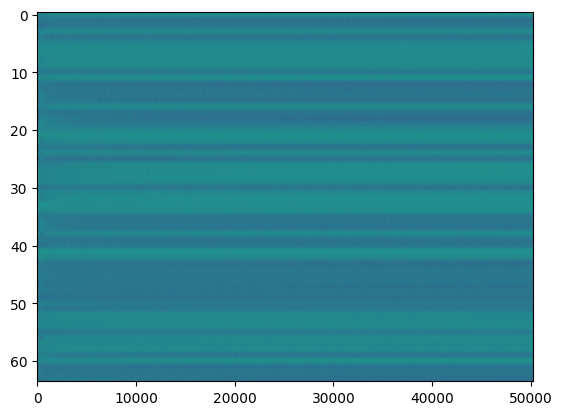

In [30]:
emb = model.params['transformer']['wte']['embedding']
print(f"{emb.shape=}")
plt.imshow(emb.T, aspect='auto')

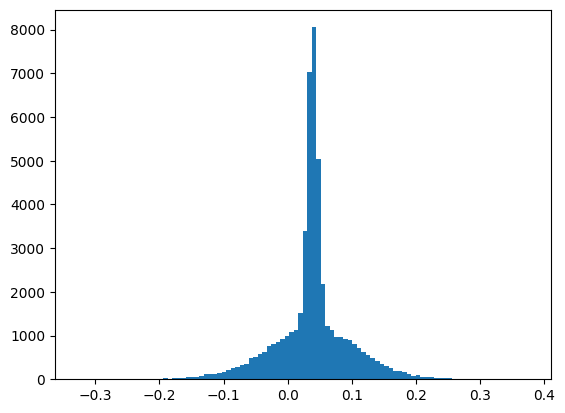

In [36]:
plt.hist(emb[:, 20], bins=100)
plt.show()


In [21]:
final_params.shape

(3745984,)

In [20]:
final_params = jax.flatten_util.ravel_pytree(model.params)[0]

In [13]:
# sample from the model
tokens = model.generate(tokenizer.encode("Once upon a time", return_tensors="jax"), max_length=100)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [11]:
tokens

FlaxGreedySearchOutput(sequences=Array([[ 7454,  2402,   257,   640,    11,   612,   373,   257,  1310,
         2576,  3706, 20037,    13,  1375,  6151,   284,   711,  2354,
          287,   262]], dtype=int32))

In [15]:
print(tokenizer.decode(tokens.sequences[0]))

Once upon a time, there was a little girl named Lily. She loved to play outside in the sunshine. One day, she saw a big, shiny rock in the sky. She wanted to touch it, but it was too high.

Lily's mommy told her that it was important to be careful and not touch things. Lily didn't want to touch it, so she asked her mommy if she could touch it. Her mommy said yes and they went to the park
